<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Monte Carlo Simulation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Monte Carlo Simulation** in Python with GeostatsPy including:

* Histograms
* Probability Density Functions
* Cumulative Distribution Functions

**YouTube Lecture**: check out my lectures on:

* [Monte Carlo Simulation](https://youtu.be/Qb8TsSINpnU?si=32y_-VFWWxlpmMXc)

For convenience here's a summary of the salient points.

#### Monte Carlo Simulation

Definition: random sampling from a distribution

Procedure: 

1. Model the representative distribution (CDF)
2. Draw a random value from a uniform [0,1] distribution (p-value)
3. Apply the inverse of the CDF to calculate the associated realization

In practice, Monte Carlo simulation refers to the workflow with multiple realizations drawn to buld an uncertainty model. 

\begin{equation}
X^\ell = F_x(p^\ell),  \, \forall \, \ell = 1,\ldots, L
\end{equation}

where $X^\ell$ is the realization of the variable $X$ drawn from its CDF, $F_x$, with cumulative probability, p-value, $p^\ell$.  

It would be trivial to apply Monte Carlo simulation to a single variable, after many realizations one would get back the original distribution. The general approach is to:

1. Model all distributions for the input, variables of interest $F_{x_1},\ldots,F_{x_m}$.
2. For each realization draw $p^\ell_{1},\ldots,p^\ell_{m}$, p-values
3. Apply the inverse of each distribution to calculate a realization of each variable, $X^\ell_j = F_{x^\ell_j}^{-1}(p^\ell_j),  \, \forall \, j = 1,\ldots$, $m$ variables.
4. Apply each set of variables for a $\ell$ realization to the transfer function to calculate the ouptput realization, $Y^\ell = F(X_1^\ell,\ldots,X_m^\ell)$.

Monte Carlo Simulation (MCS) is extremely powerful

* Possible to easily simulate uncertainty models for complicated systems 
* Simulations are conducted by drawing values at random from specified uncertainty distributions for each variable
* A single realization of each variable, $X_1^\ell, X_2^\ell,\ldots,X_m^\ell$ is applied to the transfer function to calculate the realization of the variable of interest (output, decision criteria):

\begin{equation}
Y^\ell = F(X_1^\ell,\ldots,X_m^\ell), \, \forall \, \ell = 1,\ldots, L
\end{equation}

* The MCS method builds empirical uncertainty models by random sampling

Let’s take a simple example, $OIP$ is oil-in-place calculated as the product of reservoir volume, $V$, average porosity, $\overline{\phi}$, and oil saturaton, $\overline{s_o}$:

\begin{equation}
OIP^\ell = V^\ell \cdot \overline{\phi}^\ell \cdot \overline{s_o}^\ell, \, \forall \, \ell = 1,\ldots, L
\end{equation}

It would be difficult to directly calculate the OIP distribution as a combination of all these different distributions. 
* The distributions could all have different forms (parametric or non-parametric)
* We use MCS to empirically work this out by sampling
* Repeat to calculate enough realizations for analysis.

How many realizations, $L$?

The answer is enough! If the MCS computational cost is low then **many** is the right answer. If too few realizations are calculated then the summary statistics and the entire CDF of the output, decision criteria may be incorrect. This is caused by fluctuations due to not enough samples (see the 'Law of Small Numbers').

The MCS method is very powerful. You can simulate output distributions that could not be calculated analytically.  

#### Limitations

The MCS method above assumes:
1. **representativity** - the distribution is representative
2. **independence** - the variables are independent of eachother
3. **stationarity** - all realizations for each variable are from the same distribution 

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python   

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
from scipy import stats                                       # summary statistics
import math                                                   # trig etc.
import random

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Simple Monte Carlo Simulation Example

Let's work out the OIP uncertainty example above. Let's work with parametric distributions for average porosity, $apor$, volume, $vol$ and oil saturation, $so$. Here's some parameters for these distributions. Note, these parameters could originate from a bootstrap workflow, analogs, etc. 

In [4]:
apor_mean = 0.15; apor_stdev = 0.02                           # Gaussian mean and standard deviation porosity (fraction)
vol_mu = 13.0; vol_sigma = 0.5                                # LogNormal mu and sigma volume (m^3)
so_min = 0.2; so_max = 0.4                                    # Uniform minimum and maximum oil saturation (fraction)
L = 1000                                                      # Number of MCS realizations

Let's set the minimum and maximum values for plotting.

In [5]:
apor_min = 0.1; apor_max = 0.2                                # average porosity min and max
vol_min = 0.0; vol_max = 2.0                                  # vol min and max

In the *NumPy* package we have handy methods for Monte Carlo simulation from parametric distributions. We can actually draw all $L$ realizations at once for each variable and store them in ndarrays (each ndarray with realizations $\ell = 1,\ldots,L$).  

In [6]:
apor = np.random.normal(apor_mean, apor_stdev, size=L)        # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)/1.0e6    # volume ...
so = np.random.uniform(so_min, so_max, size=L)                # saturation oil

Let's plot the distributions of the realizations of each variable to make sure the match the form of the parametric distributions that we selected.

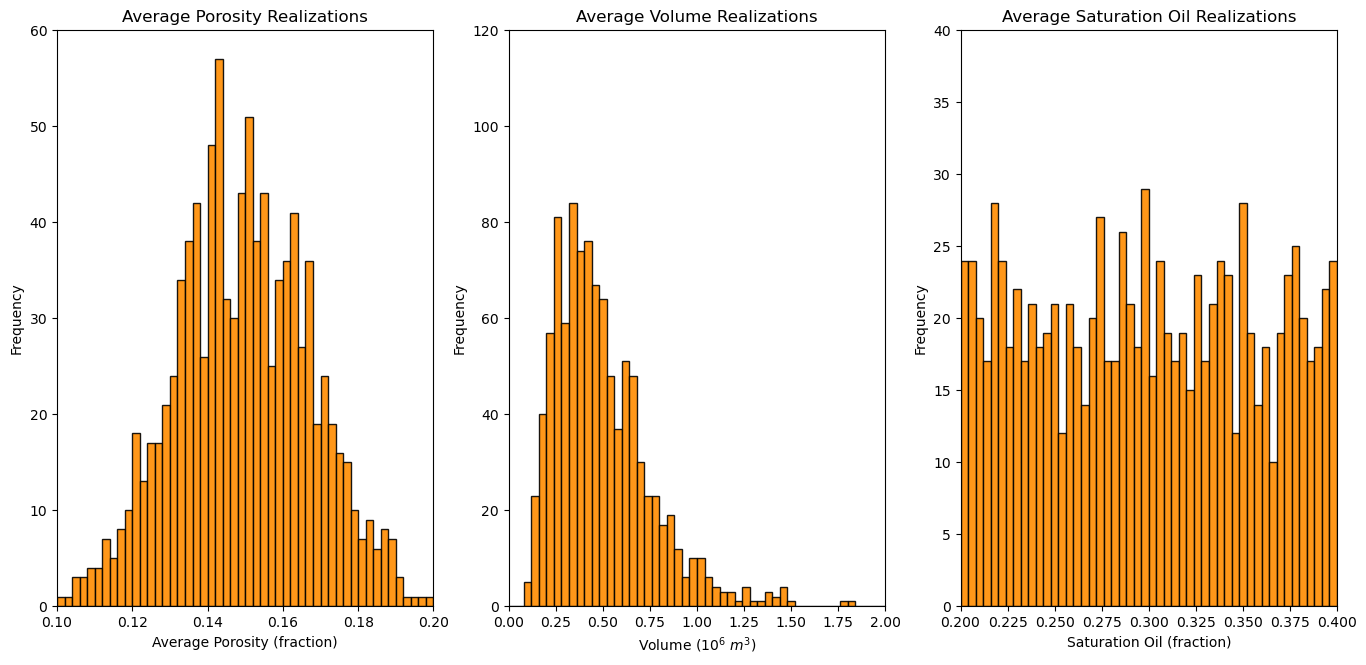

In [7]:
plt.subplot(131)
GSLIB.hist_st(apor,apor_min,apor_max,log=False,cumul=False,bins=50,weights=None,xlabel="Average Porosity (fraction)",title="Average Porosity Realizations")
plt.ylim(0.0,60)

plt.subplot(132)
GSLIB.hist_st(vol,vol_min,vol_max,log=False,cumul=False,bins=50,weights=None,xlabel="Volume ($10^6$ $m^3$)",title="Average Volume Realizations")
plt.ylim(0.0,120)

plt.subplot(133)
GSLIB.hist_st(so,so_min,so_max,log=False,cumul=False,bins=50,weights=None,xlabel="Saturation Oil (fraction)",title="Average Saturation Oil Realizations")
plt.ylim(0.0,40)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

This looks good, the shapes are Gaussian, lognormal and uniform and the central tendency and dispersion make sense given the parameters that we selected.

Now we can use broadcast methods to calculate the output realizations of $OIP$, based on this equation.

\begin{equation}
OIP^\ell = V^\ell \cdot \overline{\phi}^\ell \cdot \overline{s_o}^\ell \cdot 6.29 \quad \forall \, \ell = 1,\ldots, L
\end{equation}

where 6.26 $bbls/m^3$.

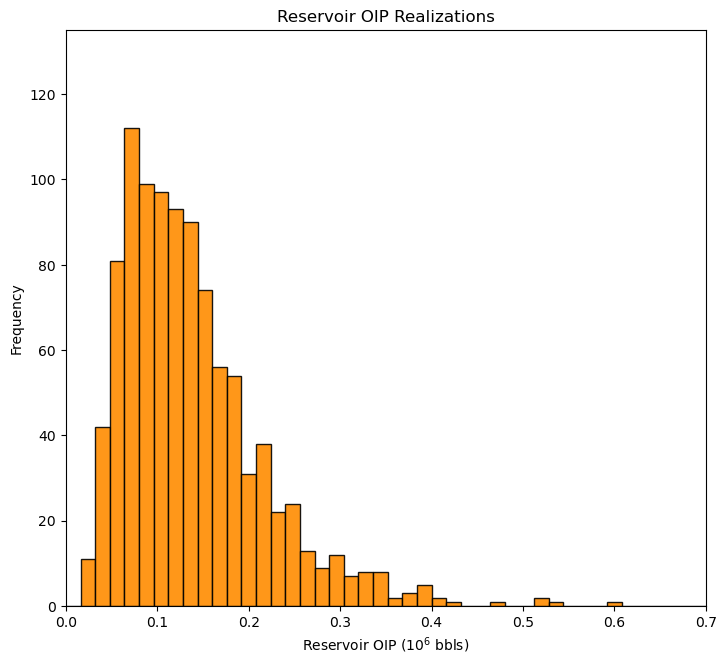

In [8]:
OIP = apor * vol * so * 6.29                                  # transfer function

plt.subplot(111)
GSLIB.hist_st(OIP,0.0,0.8,log=False,cumul=False,bins=50,weights=None,xlabel="Reservoir OIP ($10^6$ bbls)",title="Reservoir OIP Realizations")
plt.ylim(0.0,135); plt.xlim([0,0.7])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

It's not a bad idea to check your calculation. Let's compare the first and last realizations of $OIP$ to the results from performing the calculation by hand. 

In [9]:
print('Check realization 0, broadcast method = ' + str(round(OIP[0],3)) + ' compare to by-hand ' + str(round(apor[0]*vol[0]*so[0]*6.29,3)))
print('Check realization L-1, broadcast method = ' + str(round(OIP[L-1],3)) + ' compare to by-hand ' + str(round(apor[L-1]*vol[L-1]*so[L-1]*6.29,3)))

Check realization 0, broadcast method = 0.04 compare to by-hand 0.04
Check realization L-1, broadcast method = 0.19 compare to by-hand 0.19


The results check out.  

Now let's look at what happens if too few realizations are used!  Set the $L$ smaller, calculate 3 sets of $L$ realizations.

In [10]:
L = 100                                                       # set L small 
import os                                                     # set working directory, run executables
# First set of realizations
apor = np.random.normal(apor_mean, apor_stdev, size=L)        # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)/1.0e6    # volume ...
so = np.random.uniform(so_min, so_max, size=L)                # saturation oil
OIP1 = apor * vol * so * 6.29                                 # calculate OIP
    
# Second set of realizations       
apor = np.random.normal(apor_mean, apor_stdev, size=L)        # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)/1.0e6    # volume ...
so = np.random.uniform(so_min, so_max, size=L)                # saturation oil
OIP2 = apor * vol * so * 6.29                                 # calculate OIP

# Third set of realizations
apor = np.random.normal(apor_mean, apor_stdev, size=L)        # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)/1.0e6    # volume ...
so = np.random.uniform(so_min, so_max, size=L)                # saturation oil
OIP3 = apor * vol * so * 6.29                                 # calculate OIP

Let's look at the distributions, and calculate and compare the average for each of the 3 sets.

* note that I use the subplot method below that allows me to share the y axis of all the plots to improve our ability to compare the distributions.

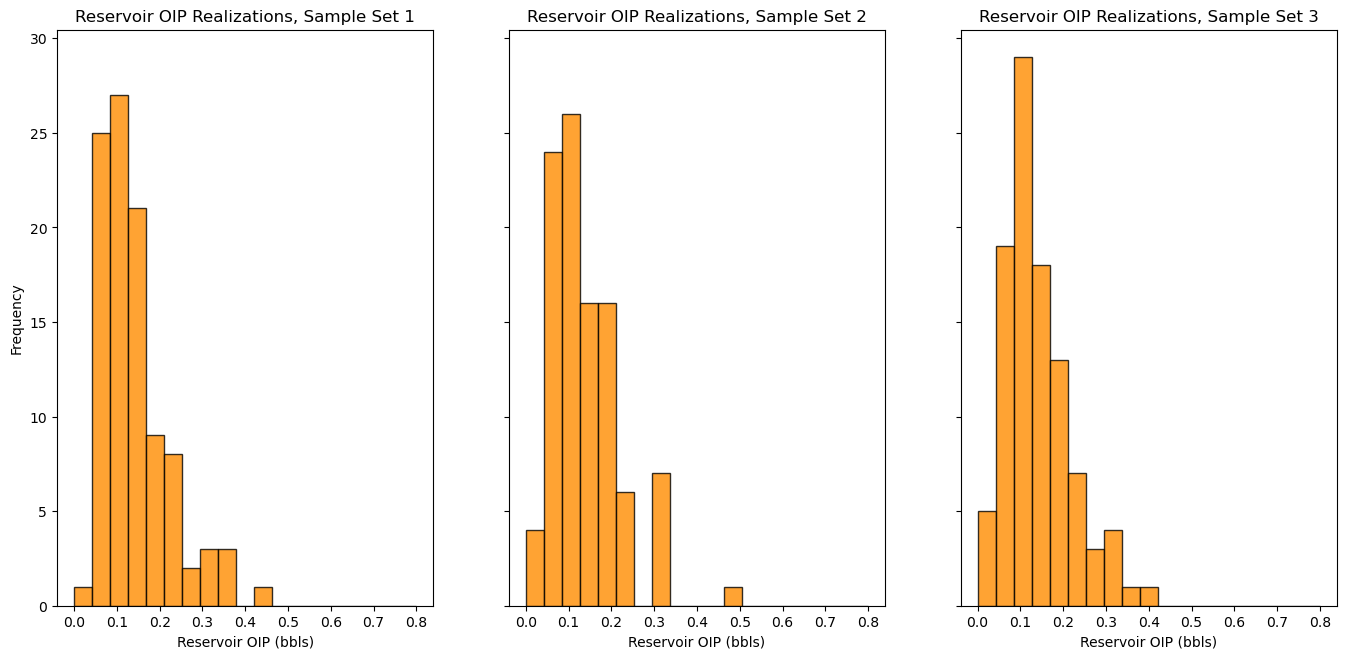

The average OIP for large number of realizations = 0.138
The average OIP for small number of realizations = 0.14, 0.141,0.142


In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(OIP1,bins=np.linspace(0.0,0.8,20),color="darkorange",edgecolor='black',alpha=0.8); ax1.set_xlabel("Reservoir OIP (bbls)"); ax1.set_ylabel("Frequency"); ax1.set_title("Reservoir OIP Realizations, Sample Set 1")
    
ax2.hist(OIP2,bins=np.linspace(0.0,0.8,20),color="darkorange",edgecolor='black',alpha=0.8); ax2.set_xlabel("Reservoir OIP (bbls)"); ax2.set_title("Reservoir OIP Realizations, Sample Set 2")

ax3.hist(OIP3,bins=np.linspace(0.0,0.8,20),color="darkorange",edgecolor='black',alpha=0.8); ax3.set_xlabel("Reservoir OIP (bbls)"); ax3.set_title("Reservoir OIP Realizations, Sample Set 3")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('The average OIP for large number of realizations = ' + str(round(np.average(OIP),3)))
print('The average OIP for small number of realizations = ' + str(round(np.average(OIP1),3)) + ', ' + str(round(np.average(OIP2),3)) + ',' + str(round(np.average(OIP3),3)))

Try setting the number of realizations, $L$, larger and you will see that the 3 sets of realizations converge, they become stable. This is why we set $L$ large. 

#### Non-Parametric Monte Carlos Simulation

I have demonstrated the case of MCS with parametric distributions. Of course, we may have non-parametric distributions. In this case we are working with a list of values (typically in an 1D ndarray). For this case we simply substitute in the command:

```p
apor = np.random.choice(array_average_porosity,size=L)
```

The result is a ndarray with $L$ Monte Carlo simulations from the array 'array_average_porosity'.  This is simply $L$ random draws with replacement (so the same value may be selected again), from the list of values in the ndarray.

#### Comments

This was a basic demonstration of Monte Carlo simulation in Python. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
